### This code based on tf-idf and random forest

### imports

In [1]:
pip install nested_lookup

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import re
import os
from nested_lookup import nested_lookup
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
from urlextract import URLExtract
import emojis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

### function

In [4]:
stopwords = []
file = open('stopwords.txt', encoding='utf-8').read()
[stopwords.append(x) for x in file.split()]
stopwords = set(stopwords)

In [5]:
def remove_general_stopwords(text):
    filtered_tokens = [token for token in text.split() if token not in stopwords]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

### vectorize

In [6]:
def vectorize_tfidf(df_X):
    tf_idf_vectorizer = TfidfVectorizer()
    tf_idf_X = tf_idf_vectorizer.fit_transform(df_X)
    tf_idf_df = pd.DataFrame(data=tf_idf_X.toarray(),columns=[tf_idf_vectorizer.get_feature_names_out()])
    return tf_idf_df

### train_test

In [7]:
def split_data(X,y,test_size):
    return train_test_split(X, y, test_size=test_size)

### define and run model

In [8]:
def define_and_run_model(model,X_train,X_test,y_train):
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

### check the result

In [9]:
def show_result(y_test,y_pred):
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))
    print(accuracy_score(y_test,y_pred))

### loading data

In [28]:
df = pd.read_csv('reviews.csv')

### Create tag for data set
* for star 0,1 and 2 I make label -1 this mean comment is negative
* for star 3 I make label 0 this mean comment is neutral
* for star 4,5 I make label 1 this mean comment is positive

In [40]:
# Create a new column for labels
df['label'] = ''

# Set labels based on star ratings
for index, row in df.iterrows():
    star_rating = row['star']
    if star_rating == 3:
        df.at[index, 'label'] = 0
    elif star_rating in [4, 5]:
        df.at[index, 'label'] = 1
    else:
        df.at[index, 'label'] = -1


In [41]:
df.rename(columns={'Unnamed: 0': 'Id'}, inplace = True)

In [13]:
df["star"].value_counts()

star
5.0    4669
4.0    3260
3.0    1007
2.0     622
1.0     430
Name: count, dtype: int64

### remove stopwords

In [47]:
# Fill NaN values with an empty string in the 'Cleaned' column
df['Cleaned'].fillna('', inplace=True)

In [48]:
df['review']=df['Cleaned'].apply(remove_general_stopwords)

In [49]:
df.head()

,Id,title,star,review,Cleaned,label
0,0,ali ghalambor,5.0,پل زیبا دوره صفویه پل کارکرد حساب آید می‌توانی...,یک پل زیبا از دوره صفویه که علاوه بر پل بودن ...,1
1,1,Shahrzad Rahimoghli,4.0,پل شاهکارهای معماری معروف ترین اماکن تاریخی اس...,سی و سه پل یکی از شاهکارهای معماری و از معروف ...,1
2,2,Alireza Fattahi,5.0,ی‌وسه‌پل پل الله‌وردی‌خان پلی 33 دهانه 295 14 ...,ی‌وسه‌پل یا پل الله‌وردی‌خان پلی است با 33 دها...,1
3,3,fatemeh momeni,5.0,وقت زاینده رود انقد آب نبوده میدون انقلاب برسی...,خیلی وقت بود زاینده رود انقد پر آب نبوده به می...,1
4,4,Naser Omrani,5.0,آب رودخانه نور پردازی زیبای ایرانیان هنرمند هس...,وقتی آب رودخانه جاری باشد با نور پردازی ای که ...,1


## Cleaning Data

In [50]:
def _multiple_replace(mapping, text):
    pattern = "|".join(map(re.escape, mapping.keys()))
    return re.sub(pattern, lambda m: mapping[m.group()], str(text))

def convert_fa_numbers(input_str):
    mapping = {
        '۰': '0',
        '۱': '1',
        '۲': '2',
        '۳': '3',
        '۴': '4',
        '۵': '5',
        '۶': '6',
        '۷': '7',
        '۸': '8',
        '۹': '9',
        '.': '.',
    }
    return _multiple_replace(mapping, input_str)


def convert_ar_characters(input_str):
    """
    Converts Arabic chars to related Persian unicode char
    :param input_str: String contains Arabic chars
    :return: New str with converted arabic chars
    """
    mapping = {
        'ك': 'ک',
        'ى': 'ی',
        'ي': 'ی',
        'ئ':'ی',
        'إ':'ا',
        'أ':'ا',
        'ة':'ه',
        'ؤ':'و'
    }
    return _multiple_replace(mapping, input_str)


def preprocess(text):
    extractor = URLExtract()
    text = str(text)
    for url in extractor.gen_urls(text):
        text = text.replace(url,'<URL>')
    emj = emojis.get(text)
    for i in emj:
        if i in text:
            text = text.replace(i,'<emoji>')
    text = convert_fa_numbers(text)
    text = convert_ar_characters(text)
    # regex to detect and replace all smilies in the text with <smiley>
    text = re.sub(r"(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:\s?D|8-\)|:\s?\||;\s?\)|:-\*|:-\||:-\(|:\s?P|:-P|:-p|:-b|:-O|:-o|:-0|:-\@|:\$|:-\^|:-&|:-\*|:-\+|:-\~|:-\`|:-\>|:-\<|:-\}|:-\{|\[:\s?\]|\[:\s?\]|:\s?\]|:\s?\[|:\s?\}|:\s?\{)",'<smiley>',text)
    text = text.lower() # we lowercase here to prevent changes in the URLs and smilies
    text = text.strip()
    text = re.sub(r'[<>#.:()"\'!?؟،,@$%^&*_+\[\]/]', ' ', text)
    text = re.sub(r'[\s]{2,}', ' ', text)
    text = re.sub(r'(\w)\1{2,}', r'\1',text)
    if re.search(r'[\u0600-\u06FF]', text):
        return text
    else:
        return 'None'

In [51]:
tqdm.pandas()

In [52]:
df['Cleaned'] = df['review'].progress_apply(preprocess)

100%|██████████████████████████████████████| 2143/2143 [00:21<00:00, 100.77it/s]


In [53]:
df['star'].fillna(0, inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['star'] = df['star'].astype(int)

In [54]:
df = df.dropna()

In [55]:
df.tail()

,Id,title,star,review,Cleaned,label
2138,2267,فاطمه دهقان,5,nice but no interest management original زیباس...,nice but no interest management original زیباس...,1
2139,2268,وحید سهرابی,3,do not go there in the busy season original فص...,do not go there in the busy season original فص...,0
2140,2269,محمدعلی بلوچ,5,great place original,None,1
2141,2270,رادف عدلی,5,مکان خنک خنک فضای دلنشین رودخانه…,مکان خنک خنک فضای دلنشین رودخانه…,1
2142,2271,امین اس,5,مکان دنج سرسبز خنک تفریح اصلی …,مکان دنج سرسبز خنک تفریح اصلی …,1


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2143 entries, 0 to 2142
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       2143 non-null   int64 
 1   title    2143 non-null   object
 2   star     2143 non-null   int64 
 3   review   2143 non-null   object
 4   Cleaned  2143 non-null   object
 5   label    2143 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 100.6+ KB


In [57]:
tf_idf_df = vectorize_tfidf(df['review'])
X_train, X_test, y_train, y_test = split_data(tf_idf_df,df['star'],.8)

### run

In [58]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
y_pred = define_and_run_model(clf, X_train, X_test, y_train)
show_result(y_test,y_pred)

[[  0   0   0   0   0   1]
 [  0   0   0   0   0  96]
 [  0   0   0   0   0  87]
 [  0   0   0   0   0 235]
 [  0   0   0   0   0 481]
 [  0   0   0   0   0 815]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        96
           2       0.00      0.00      0.00        87
           3       0.00      0.00      0.00       235
           4       0.00      0.00      0.00       481
           5       0.48      1.00      0.64       815

    accuracy                           0.48      1715
   macro avg       0.08      0.17      0.11      1715
weighted avg       0.23      0.48      0.31      1715

0.4752186588921283


### handle imbalancde data with random forest

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
rfc = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
show_result(rfc_pred, y_test)

[[  0   0   0   0   0   0]
 [  0   2   0   0   0   1]
 [  0   3   0   1   1   3]
 [  0   3   1   0   3   2]
 [  0   6   3  22  37  59]
 [  1  82  83 212 440 750]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.02      0.67      0.04         3
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         9
           4       0.08      0.29      0.12       127
           5       0.92      0.48      0.63      1568

    accuracy                           0.46      1715
   macro avg       0.17      0.24      0.13      1715
weighted avg       0.85      0.46      0.58      1715

0.46005830903790085


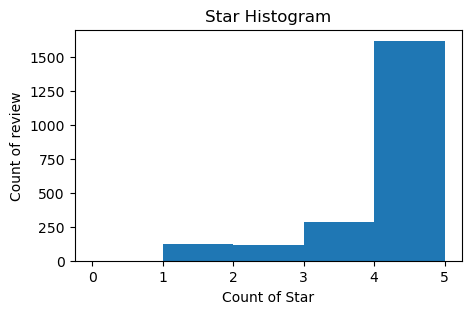

In [61]:
df.star.hist(bins=5, grid=False, figsize=(5,3))
plt.title('Star Histogram')
plt.xlabel('Count of Star')
plt.ylabel('Count of review')

plt.show()

In [62]:
df.to_csv('processed_reviews.csv', index=False)